In [4]:
import pandas as pd
mira = pd.read_csv('final_nsd_mira_full_cols.csv')
selection = (mira['amplitude']>0.4)&(mira['unreliable']==0)
miraS = mira[selection].reset_index(drop=True)
print(len(miraS))

1415


In [455]:
blg_b = np.genfromtxt('bulge_background.dat')
blg_l = np.genfromtxt('bulge_background_l.dat')

In [5]:
import agama
def build_model():
    
    agama.setUnits(length=1, velocity=1, mass=1e10)   # 1 kpc, 1 km/s, 1e10 Msun

    # initialize the SelfConsistentModel object (only the potential expansion parameters)
    model = agama.SelfConsistentModel(
        RminCyl        = 0.005,
        RmaxCyl        = 1.0,
        sizeRadialCyl  = 25,
        zminCyl        = 0.005,
        zmaxCyl        = 1.0,
        sizeVerticalCyl= 25)

    # construct a two component model: NSD + NSC
    # NSD -> generated self-consistently
    # NSC -> kept fixed as an external potential

    # NSC best-fitting model from Chatzopoulos et al. 2015 (see Equation 28 here: https://arxiv.org/pdf/2007.06577.pdf)
    density_NSC_init = agama.Density(type='Dehnen',mass=6.1e-3,gamma=0.71,scaleRadius=5.9e-3,axisRatioZ=0.73)

    # NSD model 3 from Sormani et al. 2020 (see Equation 24 here: https://arxiv.org/pdf/2007.06577.pdf)
    d1 = agama.Density(type='Spheroid',DensityNorm=0.9*222.885,gamma=0,beta=0,axisRatioZ=0.37,outerCutoffRadius=0.0050617,cutoffStrength=0.7194)
    d2 = agama.Density(type='Spheroid',DensityNorm=0.9*169.975,gamma=0,beta=0,axisRatioZ=0.37,outerCutoffRadius=0.0246,cutoffStrength=0.7933)
    density_NSD_init = agama.Density(d1,d2)

    # add both NSC and NSD components as static density profiles for the moment:
    # assign both of them to a single CylSpline potential solver by setting disklike=True
    # and thus avoid creating an additional Multipole potential, which is typically used
    # for spheroidal components - this reduces computational cost by roughly a half
    model.components.append(agama.Component(density=density_NSC_init, disklike=True))
    model.components.append(agama.Component(density=density_NSD_init, disklike=True))

    # compute the initial guess for the potential
    model.iterate()

    # introduce DF for the NSD component
    mass     = 0.097
    Rdisk    = 0.075
    Hdisk    = 0.025
    sigmar0  = 75.0
    Rsigmar  = 1.0
    sigmamin = 2.0
    Jmin     = 10.0
    dfNSD = agama.DistributionFunction(potential=model.potential, type='QuasiIsothermal',
        mass=mass, Rdisk=Rdisk, Hdisk=Hdisk, sigmar0=sigmar0, Rsigmar=Rsigmar, sigmamin=sigmamin, Jmin=Jmin)

    # replace the static density of the NSD by a DF-based component
    model.components[1] = agama.Component(df=dfNSD, disklike=True,
        RminCyl=0.005, RmaxCyl=0.75, sizeRadialCyl=20, zminCyl=0.005, zmaxCyl=0.25, sizeVerticalCyl=15)

    # iterate to make NSD DF & potential self-consistent
    for iteration in range(1,5):
        print('Starting iteration #%d' % iteration)
        model.iterate()
        
    return model, dfNSD

In [6]:
model, dfNSD = build_model()

Updating potential...Starting iteration #1
Starting iteration #2done
Updating action finder...done
Computing density for component 0...done
Computing density for component 1...done
Updating potential...done
Updating action finder...done
Computing density for component 0...done
Computing density for component 1...done
Updating potential...done
Updating action finder...done

Computing density for component 0...done
Computing density for component 1...done
Updating potential...done
Updating action finder...done
Starting iteration #3
Starting iteration #4Computing density for component 0...done
Computing density for component 1...done
Updating potential...done
Updating action finder...done

Computing density for component 0...done
Computing density for component 1...done
Updating potential...done
Updating action finder...done


In [11]:
import numpy as np
def generate_lb_samples(df):
    gm=agama.GalaxyModel(model.potential,df)
    samples = gm.sample(1000000)
    
    sgra=np.array([359.94422947-360.,-0.04615714])
    l,b,dist,pml,pmb,vlos=agama.getGalacticFromGalactocentric(*samples[0].T, galcen_distance=8.275, galcen_v_sun=(11.1,6.41*4.74*8.275,7.8))
    l,b = np.rad2deg(l)+sgra[0], np.rad2deg(b)+sgra[1]
    pml, pmb = 1./4.74*pml, 1./4.74*pmb
    
    return l,b,pml,pmb,vlos

In [12]:
l, b, pml, pmb, vlos = generate_lb_samples(dfNSD)

In [8]:
# introduce DF for the NSD component
mass     = 0.097
Rdisk    = 0.075
Hdisk    = 0.015
sigmar0  = 75.0
Rsigmar  = 1.0
sigmamin = 2.0
Jmin     = 10.0
dfNSD_different = agama.DistributionFunction(potential=model.potential, type='QuasiIsothermal',
    mass=mass, Rdisk=Rdisk, Hdisk=Hdisk, sigmar0=sigmar0, Rsigmar=Rsigmar, sigmamin=sigmamin, Jmin=Jmin)
l_d, b_d, pml_d, pmb_d, vlos_d = generate_lb_samples(dfNSD_different)

NameError: name 'np' is not defined

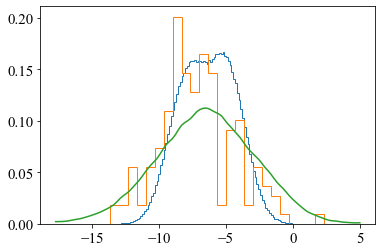

In [472]:
# plt.hist(pmb_d,range=[-5,5],histtype='step',bins=150,density=True);
plt.hist(pml,range=[-15,5],histtype='step',bins=150,density=True);
plt.hist(miraS['pml'][(miraS['period']>500)&(miraS['period']<600)
                      &(np.abs(wrap(miraS['l']))<1.5)&(np.abs(miraS['b'])<0.4)],bins=30,range=[-15,5],histtype='step',density=True);
# # vdisp=25.
# # plt.plot(xx, np.exp(-xx**2/(vdisp/4.74/8.275)**2/2.)/np.sqrt(2.*np.pi*(vdisp/4.74/8.275)**2))

plt.plot(blg_l[:,0]/4.74/8.275,blg_l[:,1]*4.74*8.275)
# plt.xlim(-5,5)

In [631]:
# np.nanpercentile(miraS['period'],[20.,40.,60.,80.])
per = [0.,220.,330.,420.,520.,1000.]
per = [80.,150.,250.,350.,450.,550.,1000.]
# per = [0.,220.,360.,420.,520.,1000.]

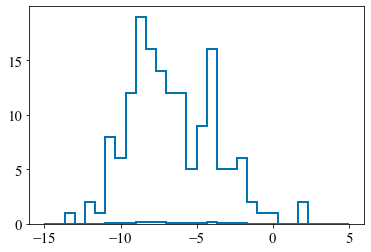

In [697]:
n_d,b_d,p=plt.hist(miraS['pml'][(miraS['period']>per[i])&(miraS['period']<per[i+1])
                          &(np.abs(wrap(miraS['l']))<1.5)&(np.abs(miraS['b'])<0.3)&(miraS['epml']<3.)],bins=30,range=[-15,5],histtype='step',density=True,
                      color=sns.color_palette('colorblind')[0],lw=2);
n_d2,b_d2,p=plt.hist(miraS['pml'][(miraS['period']>per[i])&(miraS['period']<per[i+1])
                          &(np.abs(wrap(miraS['l']))<1.5)&(np.abs(miraS['b'])<0.3)&(miraS['epml']<3.)],bins=30,range=[-15,5],histtype='step',
                      color=sns.color_palette('colorblind')[0],lw=2);

In [ ]:
nnorm = n/N/db

In [ ]:
sum(nnorm*b) = 1

In [695]:
np.sqrt(n_d/np.sum(n_d)/np.diff(b_d))

array([0.        , 0.        , 0.09837388, 0.        , 0.13912167,
       0.09837388, 0.27824334, 0.2409658 , 0.3407771 , 0.42880178,
       0.3934955 , 0.36808134, 0.3407771 , 0.3407771 , 0.21997067,
       0.29512163, 0.3934955 , 0.21997067, 0.21997067, 0.2409658 ,
       0.13912167, 0.09837388, 0.09837388, 0.        , 0.        ,
       0.13912167, 0.        , 0.        , 0.        , 0.        ])

/tmp/ipykernel_5289/42960292.py:35: RuntimeWarning: divide by zero encountered in true_divide
  return np.nansum((((1-w)*np.interp(centres,blg_l[:,0]/4.74/8.275,blg_l[:,1]*4.74*8.275/normB)
/tmp/ipykernel_5289/42960292.py:35: RuntimeWarning: divide by zero encountered in true_divide
  return np.nansum((((1-w)*np.interp(centres,blg_l[:,0]/4.74/8.275,blg_l[:,1]*4.74*8.275/normB)
/tmp/ipykernel_5289/42960292.py:35: RuntimeWarning: divide by zero encountered in true_divide
  return np.nansum((((1-w)*np.interp(centres,blg_l[:,0]/4.74/8.275,blg_l[:,1]*4.74*8.275/normB)
/tmp/ipykernel_5289/42960292.py:35: RuntimeWarning: divide by zero encountered in true_divide
  return np.nansum((((1-w)*np.interp(centres,blg_l[:,0]/4.74/8.275,blg_l[:,1]*4.74*8.275/normB)
/tmp/ipykernel_5289/42960292.py:35: RuntimeWarning: divide by zero encountered in true_divide
  return np.nansum((((1-w)*np.interp(centres,blg_l[:,0]/4.74/8.275,blg_l[:,1]*4.74*8.275/normB)
/tmp/ipykernel_5289/42960292.py:35: RuntimeWarning

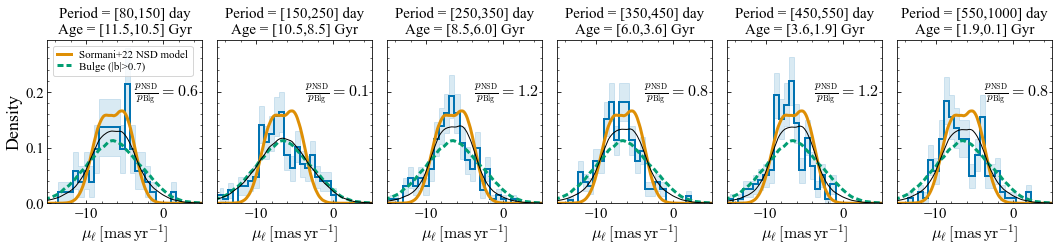

In [747]:
from scipy.optimize import minimize_scalar
from plotting_general import add_inner_ticks
f,a=plt.subplots(1,len(per)-1,figsize=[18,3],sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.1)
# plt.hist(pmb_d,range=[-5,5],histtype='step',bins=150,density=True);
for i in range(len(per)-1):
    plt.sca(a[i])
    add_inner_ticks()
    n,b=np.histogram(pml,range=[-15,5],density=True,bins=150);
    fltr = (miraS['period']>per[i])&(miraS['period']<per[i+1])\
                          &(np.abs(wrap(miraS['l']))<1.5)&(np.abs(miraS['b'])<0.3)&(miraS['epml']<3.)&(miraS['pml']<5)&(miraS['pml']>-15)
    N = np.count_nonzero(fltr)
    n_d,b_d,p=plt.hist(miraS['pml'][fltr],bins=30,range=[-15,5],histtype='step',density=True,
                      color=sns.color_palette('colorblind')[0],lw=2);
    plt.fill_between(.5*(b_d[1:]+b_d[:-1]),n_d-np.sqrt(n_d)/np.sqrt(N*np.diff(b_d)),n_d+np.sqrt(n_d)/np.sqrt(N*np.diff(b_d)),alpha=0.15,step='mid',
                    color=sns.color_palette('colorblind')[0])
    plt.title('Period = [%i,%i] day\nAge = [%0.1f,%0.1f] Gyr'%(per[i],per[i+1],6.5*(1+np.tanh((330.-per[i])/250.)),6.5*(1+np.tanh((330.-per[i+1])/250.))),
             fontsize=15)
    from scipy.ndimage import gaussian_filter1d
    plt.plot(.5*(b[1:]+b[:-1]),gaussian_filter1d(n,1),
                      color=sns.color_palette('colorblind')[1],lw=3,label='Sormani+22 NSD model')
    l,=plt.plot(blg_l[:,0]/4.74/8.275,blg_l[:,1]*4.74*8.275,
                      color=sns.color_palette('colorblind')[2],lw=3,label='Bulge (|b|>0.7)',ls='dashed')
    l.set_dashes((2,1))
    if i==0:
        plt.legend(handlelength=1.2,fontsize=11.,loc='upper left',ncol=1,labelspacing=0.1)
    plt.xlabel(r'$\mu_\ell\,[\mathrm{mas}\,\mathrm{yr}^{-1}]$',fontsize=16)
    
    centres = .5*(b_d[1:]+b_d[:-1])
    normB = np.sum(blg_l[:,1]*4.74*8.275*np.diff(blg_l[:,0]/4.74/8.275)[0])
    normS = np.sum(gaussian_filter1d(n,1)*np.diff(b))
    
    def minn(w):
        fltr = (n_d>0)
        return np.nansum((((1-w)*np.interp(centres,blg_l[:,0]/4.74/8.275,blg_l[:,1]*4.74*8.275/normB)
                       +w*np.interp(centres,.5*(b[1:]+b[:-1]),gaussian_filter1d(n,1)/normS)-n_d)**2/(np.sqrt(n_d)/np.sqrt(N*np.diff(b_d)))**2)[fltr])
    ww = minimize_scalar(minn,bounds=[0.,1.],method='bounded').x

    xx=np.linspace(-15,5,500)
    plt.plot(xx,(1-ww)*np.interp(xx,blg_l[:,0]/4.74/8.275,blg_l[:,1]*4.74*8.275)+ww*np.interp(xx,.5*(b[1:]+b[:-1]),gaussian_filter1d(n,1)),
            color='k',lw=1)
    plt.annotate(r'$\frac{p_\mathrm{NSD}}{p_\mathrm{Blg}} = %0.1f$'%(ww/(1-ww)),xy=(0.98,0.65),xycoords='axes fraction',ha='right',fontsize=16)

plt.xlim(-15,5)
# plt.ylim(0.,0.62)
plt.sca(a[0])
plt.ylabel('Density')
plt.savefig('mul_run_with_period.pdf',bbox_inches='tight')

/tmp/ipykernel_5289/407119126.py:37: RuntimeWarning: divide by zero encountered in true_divide
  return np.nansum((((1-w)*np.interp(centres,blg_b[:,0]/4.74/8.275,blg_b[:,1]*4.74*8.275/normB)
/tmp/ipykernel_5289/407119126.py:37: RuntimeWarning: divide by zero encountered in true_divide
  return np.nansum((((1-w)*np.interp(centres,blg_b[:,0]/4.74/8.275,blg_b[:,1]*4.74*8.275/normB)
/tmp/ipykernel_5289/407119126.py:37: RuntimeWarning: divide by zero encountered in true_divide
  return np.nansum((((1-w)*np.interp(centres,blg_b[:,0]/4.74/8.275,blg_b[:,1]*4.74*8.275/normB)
/tmp/ipykernel_5289/407119126.py:37: RuntimeWarning: divide by zero encountered in true_divide
  return np.nansum((((1-w)*np.interp(centres,blg_b[:,0]/4.74/8.275,blg_b[:,1]*4.74*8.275/normB)
/tmp/ipykernel_5289/407119126.py:37: RuntimeWarning: divide by zero encountered in true_divide
  return np.nansum((((1-w)*np.interp(centres,blg_b[:,0]/4.74/8.275,blg_b[:,1]*4.74*8.275/normB)


0.16333955182215948 0.22250448030461947 0.1952280069864615 0.3178632229110939
0.32427647765637996 0.12643774015080025 0.4798952040794554 0.27691000694313833
0.5526575920290258 0.122710450039242 1.2354241006027868 0.6131989557120958
0.6054503317484374 0.10638794761341308 1.5345351433989949 0.683422174083196
0.7463321672843644 0.14195067800880193 2.9421632190984606 2.206005924289569
0.605375361567151 0.17028481951478214 1.5340536363143586 1.0934716793513024


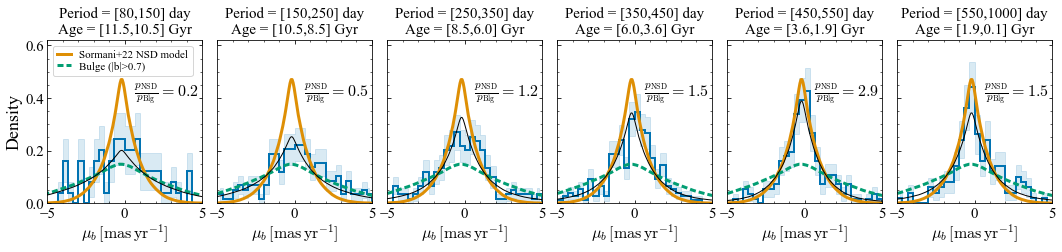

In [779]:
from scipy.optimize import minimize_scalar
from plotting_general import add_inner_ticks
f,a=plt.subplots(1,len(per)-1,figsize=[18,3],sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.1)
# plt.hist(pmb_d,range=[-5,5],histtype='step',bins=150,density=True);
for i in range(len(per)-1):
    plt.sca(a[i])
    add_inner_ticks()
    n,b=np.histogram(mock_pmb[(period>per[i])&(period<per[i+1])&(np.abs(mock_b)<0.3)],range=[-5,5],density=True,bins=150);
    n,b=np.histogram(pmb,range=[-5,5],density=True,bins=150);
    fltr = (miraS['period']>per[i])&(miraS['period']<per[i+1])\
                          &(np.abs(wrap(miraS['l']))<1.5)&(np.abs(miraS['b'])<0.3)&(miraS['epmb']<3.)&(np.abs(miraS['pmb'])<5)
    N = np.count_nonzero(fltr)
    n_d,b_d,p=plt.hist(miraS['pmb'][fltr],bins=30,range=[-5,5],histtype='step',density=True,
                      color=sns.color_palette('colorblind')[0],lw=2);
    plt.fill_between(.5*(b_d[1:]+b_d[:-1]),n_d-np.sqrt(n_d)/np.sqrt(N*np.diff(b_d)),
                     n_d+np.sqrt(n_d)/np.sqrt(N*np.diff(b_d)),alpha=0.15,step='mid',
                    color=sns.color_palette('colorblind')[0])
    plt.title('Period = [%i,%i] day\nAge = [%0.1f,%0.1f] Gyr'%(per[i],per[i+1],6.5*(1+np.tanh((330.-per[i])/250.)),6.5*(1+np.tanh((330.-per[i+1])/250.))),
             fontsize=15)
    from scipy.ndimage import gaussian_filter1d
    plt.plot(.5*(b[1:]+b[:-1]),gaussian_filter1d(n,1),
                      color=sns.color_palette('colorblind')[1],lw=3,label='Sormani+22 NSD model')
    l,=plt.plot(blg_b[:,0]/4.74/8.275,blg_b[:,1]*4.74*8.275,
                      color=sns.color_palette('colorblind')[2],lw=3,label='Bulge (|b|>0.7)',ls='dashed')
    l.set_dashes((2,1))
    if i==0:
        plt.legend(handlelength=1.2,fontsize=11.,loc='upper left',ncol=1,labelspacing=0.1)
    plt.xlabel(r'$\mu_b\,[\mathrm{mas}\,\mathrm{yr}^{-1}]$',fontsize=16)
    
    centres = .5*(b_d[1:]+b_d[:-1])
    normB = np.sum(blg_b[:,1]*4.74*8.275*np.diff(blg_b[:,0]/4.74/8.275)[0])
    normS = np.sum(gaussian_filter1d(n,1)*np.diff(b))
    
    def minn(w):
        fltr = (n_d>0)
        return np.nansum((((1-w)*np.interp(centres,blg_b[:,0]/4.74/8.275,blg_b[:,1]*4.74*8.275/normB)
                       +w*np.interp(centres,.5*(b[1:]+b[:-1]),gaussian_filter1d(n,1)/normS)-n_d)**2/(np.sqrt(n_d)/np.sqrt(N*np.diff(b_d)))**2)[fltr])
    ww = minimize_scalar(minn,bounds=[0.,1.],method='bounded').x
    curv = 1./np.sqrt((-2*minn(ww)+minn(ww+0.02)+minn(ww-0.02))/0.04**2)
    ert = curv/(1-ww)**2
    print(ww,curv,ww/(1-ww),ert)

    xx=np.linspace(-5,5,500)
    plt.plot(xx,(1-ww)*np.interp(xx,blg_b[:,0]/4.74/8.275,blg_b[:,1]*4.74*8.275)+ww*np.interp(xx,.5*(b[1:]+b[:-1]),gaussian_filter1d(n,1)),
            color='k',lw=1)
    plt.annotate(r'$\frac{p_\mathrm{NSD}}{p_\mathrm{Blg}} = %0.1f$'%(ww/(1-ww)),xy=(0.98,0.65),xycoords='axes fraction',ha='right',fontsize=16)

plt.xlim(-5,5)
plt.ylim(0.,0.62)
plt.sca(a[0])
plt.ylabel('Density')
plt.savefig('mub_run_with_period.pdf',bbox_inches='tight')

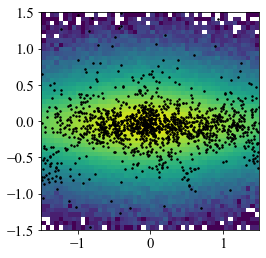

In [770]:
import numpy as np
from matplotlib.colors import LogNorm
sgra=np.array([359.94422947-360.,-0.04615714])
l2,b2 = np.rad2deg(np.arctan2(samples[0][:,1],samples[0][:,0]+8.275))+sgra[0], \
        np.rad2deg(np.arcsin(samples[0][:,2]/np.sqrt((samples[0][:,0]+8.275)**2+samples[0][:,1]**2)))+sgra[1]

l,b,dist,pml,pmb,vlos=agama.getGalacticFromGalactocentric(*samples[0].T, galcen_distance=8.275, galcen_v_sun=(11.1,6.41*4.74*8.275,7.8))
l,b = np.rad2deg(l)+sgra[0], np.rad2deg(b)+sgra[1]
pml, pmb = 1./4.74*pml, 1./4.74*pmb

# pml = ((samples[0][:,4]-251.)*np.cos(np.deg2rad(l))-(samples[0][:,3]-11.1)*np.sin(np.deg2rad(l)))/4.74/np.sqrt((samples[0][:,0]+8.275)**2+samples[0][:,1]**2+samples[0][:,2]**2)
# pmb = samples[0][:,

plt.hist2d(l,b,range=[[-1.5,1.5],[-1.5,1.5]],bins=50,norm=LogNorm())
plt.gca().set_aspect('equal')

def wrap(x):
    return x-360.*(x>180.)
plt.plot(wrap(miraS['l']),miraS['b'],'k.',ms=3)

In [ ]:
import matplotlib.pyplot as plt
plt.title('Sormani+ (2022) NSD model',fontsize=20)
dist=8.275
plt.hist((dist*pmb*4.74),range=[-450,450],bins=200,histtype='step',density=True);
# plt.hist((dist*gl.pm_b*4.74)[(np.abs(gl.b.deg)>0.9)&fltr&(bdf['pmra_error']<0.5)],range=[-450,450],bins=100,histtype='step',density=True);
# plt.hist((dist*gl.pm_b*4.74)[(np.abs(gl.b.deg)>0.7)&(np.abs(gl.b.deg)<0.9)&fltr],label='0.7<|b|<0.9',range=[-450,450],bins=100,histtype='step',density=True);
# n,b,p=plt.hist((dist*gl.pm_b*4.74)[(np.abs(gl.b.deg)<0.7)&fltr],label='0.6<|b|<0.7',range=[-450,450],bins=100,histtype='step',density=True);

plt.xlabel('Vertical velocity [km/s]')
plt.ylabel('Density')
plt.legend()
# xx = np.linspace(-350,350,1000)
# sg = 100.
# plt.plot(xx, np.exp(-(xx+10.)**2/2./(sg)**2)/np.sqrt(2.*np.pi*(sg)**2))

In [771]:
def find_nearby(ldata,bdata,l,b):
    return np.argsort(np.sqrt((ldata-l)**2+(bdata-b)**2))[:100]

In [772]:
indx=np.concatenate([find_nearby(wrap(miraS['l'].values[ii]),miraS['b'].values[ii],l,b) for ii in range(len(miraS))])

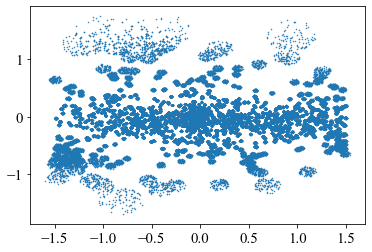

In [773]:
plt.plot(l[indx],b[indx],'.',ms=1)

In [774]:
errors=np.outer(miraS['epml'].values,np.ones(100)).flatten()
mock_pml = pml[indx] + np.random.normal(0.,errors)

errors=np.outer(miraS['epmb'].values,np.ones(100)).flatten()
mock_pmb = pmb[indx] + np.random.normal(0.,errors)

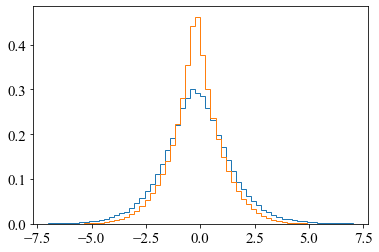

In [775]:
plt.hist(mock_pmb,bins=60,range=[-7,7],histtype='step',density=True);
plt.hist(pmb,bins=60,range=[-7,7],histtype='step',density=True);

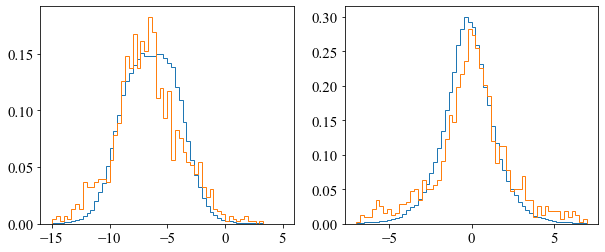

In [776]:
import matplotlib.pyplot as plt
f,a=plt.subplots(1,2,figsize=[10,4])
plt.sca(a[0])
plt.hist(mock_pml,bins=60,range=[-15,5],histtype='step',density=True);
plt.hist(miraS['pml'],bins=60,range=[-15,5],histtype='step',density=True);

plt.sca(a[1])
plt.hist(mock_pmb,bins=60,range=[-7,7],histtype='step',density=True);
plt.hist(miraS['pmb'],bins=60,range=[-7,7],histtype='step',density=True);

# plt.axvline(-6.379,color='k')
# plt.axvline(-6.41)

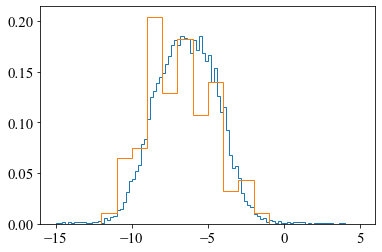

In [306]:
period=np.outer(miraS['period'].values,np.ones(100)).flatten()
mock_l=np.outer(wrap(miraS['l']).values,np.ones(100)).flatten()
mock_b=np.outer(miraS['b'].values,np.ones(100)).flatten()

import seaborn as sns
plt.hist(mock_pml[(period>400)&(np.abs(mock_l)>1.)&(np.abs(mock_b)<0.4)],bins=100,range=[-15,5],histtype='step',density=True);
plt.hist(miraS['pml'][(miraS['period']>400)&(np.abs(wrap(miraS['l']))>1.)&(np.abs(miraS['b'])<0.4)],bins=20,range=[-15,5],histtype='step',density=True);

# plt.hist(mock_pml[(period<400)&(np.abs(mock_l)<0.15)&(np.abs(mock_b)<0.4)],bins=100,range=[-15,5],histtype='step',density=True);
# plt.hist(miraS['pml'][(miraS['period']<400)&(np.abs(wrap(miraS['l']))<0.15)&(np.abs(miraS['b'])<0.4)],bins=20,range=[-15,5],histtype='step',density=True);

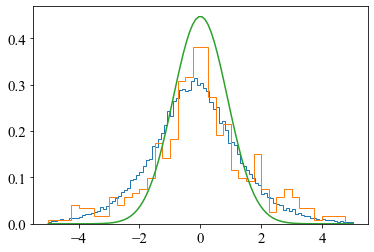

In [317]:
period=np.outer(miraS['period'].values,np.ones(100)).flatten()
mock_l=np.outer(wrap(miraS['l']).values,np.ones(100)).flatten()
mock_b=np.outer(miraS['b'].values,np.ones(100)).flatten()

import seaborn as sns
plt.hist(mock_pmb[(period>400)&(np.abs(mock_l)<1.5)&(np.abs(mock_b)<0.4)],bins=100,range=[-5,5],histtype='step',density=True);
plt.hist(miraS['pmb'][(miraS['period']>400)&(np.abs(wrap(miraS['l']))<1.5)&(np.abs(miraS['b'])<0.4)],bins=40,range=[-5,5],histtype='step',density=True);
xx = np.linspace(-5,5,100)
vdisp=35.
plt.plot(xx, np.exp(-xx**2/(vdisp/4.74/8.275)**2/2.)/np.sqrt(2.*np.pi*(vdisp/4.74/8.275)**2))

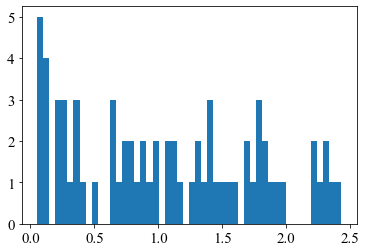

In [337]:
plt.hist(mira['maser_SiO_dist'],bins=50);

/home/jls/miniconda3/envs/chemevo/lib/python3.10/site-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


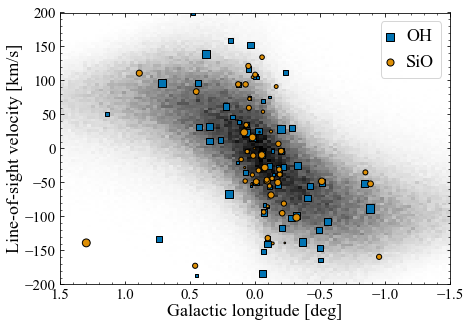

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sgra=np.array([359.94422947-360.,-0.04615714])
plt.figure(figsize=[7.,5.])
plt.hist2d((-(l-sgra[0])+sgra[0])[np.abs(b)<0.4],vlos[np.abs(b)<0.4],
           range=[[-1.5,1.5],[-200,200]],bins=100,cmap=plt.cm.Greys,vmax=350);

fltr = (mira['unreliable']==0)&(mira['amplitude']>0.4)&(np.abs(mira['b'])<0.4)
plt.scatter((mira['l']-360.*(mira['l']>180.))[fltr],mira['maser_OH_rv'][fltr],s=(mira['period'][fltr]-350)/20.*2.5,
            color=sns.color_palette('colorblind')[0],edgecolor='k',marker='s',label='OH')
plt.scatter((mira['l']-360.*(mira['l']>180.))[fltr],mira['maser_SiO_rv'][fltr],s=(mira['period'][fltr]-350)/20.*2.5,
            color=sns.color_palette('colorblind')[1],edgecolor='k',label='SiO')
plt.gca().invert_xaxis()
lgnd=plt.legend(fontsize=18,handlelength=0.2)
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
plt.xlabel('Galactic longitude [deg]')
plt.ylabel('Line-of-sight velocity [km/s]')
# plt.ylim(-500,500)
from plotting_general import add_inner_ticks
add_inner_ticks()
plt.savefig('maser.pdf',bbox_inches='tight')

(array([ 1.,  0.,  6., 12., 20., 15., 16.,  5.,  4.,  1.]),
 array([179.66327725, 258.76800018, 337.87272311, 416.97744604,
        496.08216898, 575.18689191, 654.29161484, 733.39633777,
        812.5010607 , 891.60578363, 970.71050657]),
 <BarContainer object of 10 artists>)

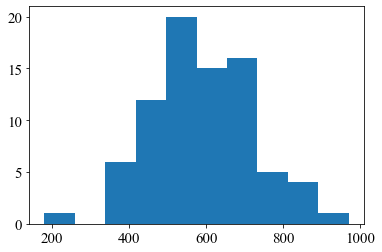

In [351]:
plt.hist(mira['period'][fltr&(mira['maser_OH_rv']>-1000)]);